In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf 
import os 

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=32 
epochs=100 
num_classes=10 
depth=20 

In [4]:
model_type = 'ResNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
x_train = x_train/255 
x_test = x_test/255 

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
input_shape=x_train.shape[1:]

170500096/170498071 [==============================] - 4s 0us/step


In [6]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')
    x = inputs 
    if conv_first:
        x = conv(x) 
        if batch_normalization:
            x = BatchNormalization()(x) 
        if activation is not None:
            x = Activation(activation)(x)

    else: 
        if batch_normalization:
            x = BatchNormalization()(x) 
        if activation is not None:
            x = Activation(activation)(x) 
        x = conv(x) 
    return x

In [7]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2)%6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20,32, 44 in [a])')

    # model definition 
    num_filters = 16 
    num_res_blocks = int((depth-2)/6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) 

    ## instantiate the stack of residual units 
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1 
            if stack > 0 and res_block ==0: # first layer but not first stack 
                strides = 2 # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0: # first layer but not first stack 
                # linear projection residual shortcut connection to match changed dimes 
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x) 
            x = Dropout(rate=0.25)(x) 
        num_filters *= 2 

    # Add classifier on top 
    # v1 does not use BN after last shortcut connection to match changed dims 
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x) 

    outputs = Dense(num_classes, activation='softmax')(y)

    # Instantiate model 
    model = Model(inputs=inputs, outputs=outputs)
    return model          

In [8]:
model = resnet_v1(input_shape=input_shape, depth=depth)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [10]:
model.summary() 
print(model_type)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
save_dir = os.path.join(os.getcwd(), 'saved_models') 
model_name = 'cifar10_%s_model.{epoch:03d}.h5'%model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [12]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=2, save_best_only=True)

In [13]:
callbacks = [checkpoint] 

In [14]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/100
1250/1250 [==============================] - 50s 14ms/step - loss: 1.6573 - accuracy: 0.3819 - val_loss: 2.1462 - val_accuracy: 0.3184

Epoch 00001: val_accuracy improved from -inf to 0.31840, saving model to /content/saved_models/cifar10_ResNet20_model.001.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.3075 - accuracy: 0.5251 - val_loss: 1.4892 - val_accuracy: 0.4717

Epoch 00002: val_accuracy improved from 0.31840 to 0.47170, saving model to /content/saved_models/cifar10_ResNet20_model.002.h5
Epoch 3/100
1250/1250 [==============================] - 17s 13ms/step - loss: 1.1312 - accuracy: 0.5956 - val_loss: 1.0990 - val_accuracy: 0.6220

Epoch 00003: val_accuracy improved from 0.47170 to 0.62200, saving model to /content/saved_models/cifar10_ResNet20_model.003.h5
Epoch 4/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.0399 - accuracy: 0.6304 - val_loss: 1.1341 - val_accuracy: 0.6085

Epoch 00004: val_accuracy did not improve from 0.62200
Epoch 5/100
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9762 - accuracy: 0.6557 - val_loss: 0.9715 - val_accuracy: 0.6515

Epoch 00005: val_accuracy improved from 0.62200 to 0.65150, saving model to /content/saved_models

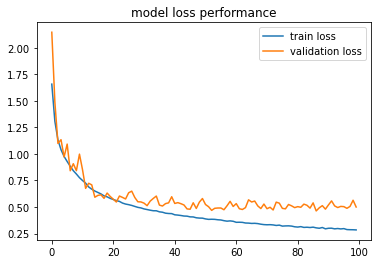

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

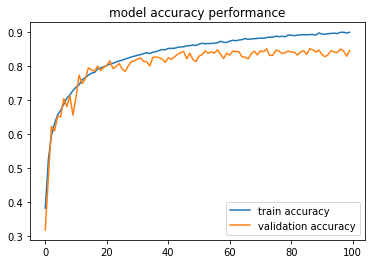

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [17]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.4973 - accuracy: 0.8466


[0.4973107874393463, 0.8465999960899353]